In [1]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
import time
from tqdm import tqdm
import datetime as dt
from collections import Counter


# text processing
import re
with open('stopwords-de.json', 'r') as file:
    stopwords_de = json.load(file)
import spacy
nlp = spacy.load('de')


# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# SK-LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover

In [80]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')


  0%|          | 0/8 [00:00<?, ?it/s]

Loading: ['08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09']



100%|██████████| 8/8 [01:06<00:00,  8.26s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

AfD loaded



100%|██████████| 8/8 [00:20<00:00,  2.55s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

SPD loaded



100%|██████████| 8/8 [00:17<00:00,  2.21s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

CDU loaded



100%|██████████| 8/8 [00:15<00:00,  1.90s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

CSU loaded



100%|██████████| 8/8 [00:47<00:00,  5.89s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

FDP loaded



100%|██████████| 8/8 [00:13<00:00,  1.72s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

LINKE loaded



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

Gruene loaded



100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Grüne loaded
Done


In [82]:
collapse = True
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

dumping data to pickle
data dumped


# LDA using the scikit-learn package

In [4]:
cv = CountVectorizer(stop_words=stopwords_de,
                    max_df=.1,
                    max_features=5000)

X = cv.fit_transform(all_data.loc[:, 'clean_text'])

In [5]:
lda = LatentDirichletAllocation(n_components=5,
                               random_state=123,
                               learning_method='batch')

X_topics = lda.fit_transform(X)

In [6]:
lda.components_.shape

(5, 5000)

In [7]:
n_top_words = 5
feature_names = cv.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print('Topic {}'.format(topic_idx + 1))
    print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]]))

Topic 1
aufstehen partei sammlungsbewegung linken wagenknecht
Topic 2
ueber nazis partei waehler rechts
Topic 3
cdu fdp csu wehrpflicht merkel
Topic 4
gruene politik einfach leute muessen
Topic 5
gruene deutschland csu seehofer bayern


In [47]:
def daily_topifier(df, cv_features, n_topics, n_top_words):
    dates = ['2018-08-{:02d}'.format(i) for i in range(2,10)]
    topics = {}
    
    for date in dates:
        cv = CountVectorizer(stop_words=stopwords_de, max_df=.1, max_features=cv_features)
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=123, learning_method='batch')
        X = cv.fit_transform(df.loc['{}'.format(date), 'clean_text'])
        X_topics = lda.fit_transform(X)
        feature_names = cv.get_feature_names()
        for topic_idx, topic in enumerate(lda.components_):
            topics['{}, {}'.format(date, topic_idx + 1)] = [' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]])]
            
    return topics

In [51]:
topics = daily_topifier(all_data, cv_features=5000, n_topics=5, n_top_words=5)

topics
# interesting: afd is very common but does not appear to be a topic

# LDA using gensim 

- take only words with certain tags from the cleaned text (tags in this context referring to word tags = nouns, adjectives, ect.)
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
- run lda on corpus and evaluate coherence using the coherence model and visualizations

In [297]:
def sparse_text(text, nlp):
    """
    Keep only verbs, nouns, adjectives and advers that are not in the list of stopwords and longer than two letters
    
    Parameters:
    text: string
    nlp: spacy function loaded in the preamble
    """
    text_out = []
    wanted_tags = keep_tags(text, nlp)
    
    for word in wanted_tags:
        if ((word.lower() not in stopwords_de)
            and (len(word) > 2)):
            text_out.append(word)
    
    return text_out
            
            
def keep_tags(text, nlp):
    """
    Only keep nouns (NN) and adjectives(ADJA) from a string
    
    Parameters:
    text: string
    nlp: spacy function loaded in the preamble
    """
    nlp_text = nlp(text)
    wanted = ["ADJA", "NN", 'ADV', 'VERB']
    wanted_words = [word.text for word in nlp_text if word.tag_ in wanted]
    return wanted_words

In [298]:
text = all_data.loc[:, 'clean_text']

document = []

for row in text.iteritems():
    index, data = row
    document.append(data)

In [300]:
lengths = len(document)
corpus = []
for i, term in enumerate(document):
    corpus.append(sparse_text(term, nlp))
    print('{}/{}'.format(i, lengths), end='\r')

In [301]:
common_dictionary = corpora.Dictionary(corpus, prune_at=100000)

In [302]:
common_corpus = [common_dictionary.doc2bow(row) for row in corpus]

In [303]:
path_corpus = '../Data/lda_cleaned_corpus.pkl'
path_dic = '../Data/lda_cleaned_dic.pkl'
with open(path_corpus, 'wb') as fid:
    pickle.dump(common_corpus, fid)

with open(path_dic, 'wb') as fid:
    pickle.dump(common_dictionary, fid)

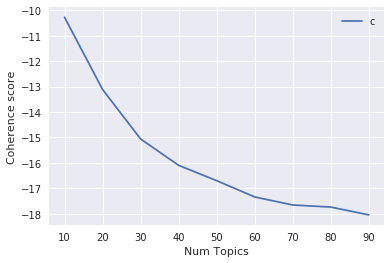

In [321]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, 
                       id2word=dictionary, 
                       num_topics=num_topics, 
                       alpha=0.001, 
                       minimum_probability=0.2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=100, start=10, step=10)

Following from coherence score curve
- choose 22 topics: highest coherence score before curve flattens out 
- given the corpus 20 topics make more sense than 80 - this can also be seen in the LDA visualization: with 80 topics, most of them cluster in the lower-right corner

Following from LDA visualization
- comparing topic-bubbles of different numbers of topics: chosing 17 topics results in nicely distributed, hardly overlapping clusters

In [322]:
lda = LdaModel(common_corpus, 
               num_topics=40, 
               id2word=common_dictionary, 
               alpha=0.001, 
               random_state=123, 
               minimum_probability=0.2,
               per_word_topics=True)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score c_v: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score u-mass: ', coherence_lda)

perplexity = lda.log_perplexity(common_corpus)
print('Model perplexity: ', perplexity)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

Coherence Score c_v:  0.577417053906
Coherence Score u-mass:  -16.148425458
Model perplexity:  -13.7504848734


https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [331]:
lda.top_topics(corpus=common_corpus)

[([(0.11611071, 'Klimawandel'),
   (0.037510283, 'Sammelbewegung'),
   (0.035783961, 'Ideologie'),
   (0.03160321, 'Demokratie'),
   (0.022615083, 'Werte'),
   (0.022137519, 'soziale'),
   (0.021200893, 'Blick'),
   (0.018040378, 'Kosten'),
   (0.016673179, 'Positionen'),
   (0.015409702, 'Hilfe'),
   (0.015051554, 'Schule'),
   (0.012794786, 'Energiewende'),
   (0.012649757, 'Auslaender'),
   (0.011805871, 'Spektrum'),
   (0.011561305, 'Steuerzahler'),
   (0.011505001, 'Neues'),
   (0.0095258597, 'Partei'),
   (0.0090149641, 'Verbrecher'),
   (0.0087966118, 'Gerechtigkeit'),
   (0.008548215, 'absolute')],
  -12.970464622973111),
 ([(0.071270771, 'Fluechtlinge'),
   (0.040500119, 'Deutschen'),
   (0.040139761, 'Bundestag'),
   (0.035875183, 'Themen'),
   (0.035226185, 'Debatte'),
   (0.033502724, 'Migranten'),
   (0.032914698, 'Sommer'),
   (0.027701339, 'Grenzen'),
   (0.021182377, 'Sachen'),
   (0.019982252, 'Loesung'),
   (0.015615266, 'Zahlen'),
   (0.01401592, 'Vorschlag'),
   (0.

In [332]:
lda.get_topic_terms()

<bound method LdaModel.get_topic_terms of <gensim.models.ldamodel.LdaModel object at 0x7f7a57646048>>

In [325]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=all_data.loc[:, 'clean_text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: '<' not supported between instances of 'int' and 'tuple'

In [233]:
def daily_lda(df, stoplist, n_topics, n_words, startdate, stopdate):
    dates = ['2018-08-{:02d}'.format(i) for i in range(startdate, stopdate)]
    topics = {}
    
    for date in dates:
        text = all_data.loc['{}'.format(date), 'clean_text']

        document = []

        for row in text.iteritems():
            index, data = row
            document.append(data)

        corpus = [[word for word in str(doc).lower().split() if word not in stoplist and len(word) > 2] for doc in document]
        common_dictionary = corpora.Dictionary(corpus)
        common_corpus = [common_dictionary.doc2bow(t) for t in corpus]
        lda = LdaModel(common_corpus, num_topics=n_topics, id2word=common_dictionary, alpha=0.001, random_state=123)
        topic = lda.show_topics(num_topics=n_topics, num_words=n_words,formatted=False)
        topics['{}'.format(date)] = [(tp[0], [wd[0] for wd in tp[1]]) for tp in topic]
        
        coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('Coherence Score: ', coherence_lda)
    return topics

KeyboardInterrupt: 

In [172]:
daily_topics = daily_lda(all_data, stoplist=stopwords_de, n_topics=17, n_words=5, startdate=2, stopdate=3)

Coherence Score:  0.572570466436


In [173]:
daily_topics

{'2018-08-02': [(0, ['sommer', 'letzten', 'bringen', 'millionen', 'paar']),
  (1, ['eher', 'deutschland', 'seehofer', 'regierung', 'kirche']),
  (2, ['kritik', 'seehofer', 'ard', 'pflege', 'problem']),
  (3, ['nato', 'pro', 'journalisten', 'passt', 'logik']),
  (4, ['bayern', 'bild', 'hitze', 'themen', 'bitte']),
  (5, ['berlin', 'retten', 'weiss', 'staedte', 'religion']),
  (6, ['klimawandel', 'grad', 'ideologie', 'werte', 'blume']),
  (7, ['mitte', 'energiewende', 'klimawandel', 'europa', 'politik']),
  (8, ['wald', 'hitzewelle', 'naechsten', 'deutschland', 'hamburg']),
  (9, ['antideutsche', 'rechts', 'partei', 'arbeit', 'seite']),
  (10, ['sagen', 'klimaschutz', 'baden', 'fordert', 'deutschen']),
  (11, ['bringt', 'libyen', 'dielinke', 'partei', 'taeglich']),
  (12, ['soeder', 'horst', 'union', 'seehofer', 'letzte']),
  (13, ['groko', 'bauern', 'landwirtschaft', 'duerre', 'sammlungsbewegung']),
  (14, ['fordern', 'deutschland', 'mitte', 'sowas', 'autos']),
  (15, ['land', 'merkel',

In [159]:
df_topics = pd.DataFrame(daily_topics)

In [176]:
df_topics = df_topics.transpose()

In [ ]:
user_text = df_part.loc[:, ['user_id', 'clean_text']]
user_text.reset_index()
user_text = pd.DataFrame(user_text.groupby(user_text['user_id'])['clean_text'].apply(lambda x: '. '.join(x.astype(str))))

user_tags = df_part.loc[:, ['user_id', 'topics']]
user_tags.reset_index()
user_tags = pd.DataFrame(user_tags.groupby(user_tags['user_id'])['tags'].apply(lambda x: '. '.join(x.astype(str))))

user_tweetcount = pd.DataFrame(df_part.loc[:, 'user_id'].groupby(df_part['user_id']).count())

user_dflist = [user_text, user_tags, user_tweetcount]